# Install environment

In [1]:
!pip install -r requirements.txt

# Datasets preparation

Download the provided dataset from this google link:

- `https://drive.google.com/file/d/15fziaX7zUI1iHDBfGWflB5RVibIhcXGz/view`

And unzip and move the dataset to the main directory.
- `tar -xvf maps.tar`
- `mv maps to maps_generation`


# Training

### import some necessary tools

In [21]:
import time
import os
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from tensorboardX import SummaryWriter
from util import util
import datetime
import ipdb

### initialize and modify the optional arguments

In [22]:
opt = TrainOptions().parse()

----------------- Options ---------------
               batch_size: 32                            
                    beta1: 0.5                           
          checkpoints_dir: ./train_output/ckpt/          
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./maps/                       
             dataset_mode: map                           
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1  

### prepare datasets and models

In [23]:
dataset = create_dataset(opt)
dataset_size = len(dataset)
print('The number of training images = %d' % dataset_size)
model = create_model(opt)
model.setup(opt)

dataset [MapDataset] was created
The number of training images = 1096
initialize network with normal
initialize network with normal
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
[Network D] Total number of parameters : 2.769 M
-----------------------------------------------


### prepare some parameters for training

In [24]:
total_iters = 0
log_name = os.path.join(opt.checkpoints_dir, opt.name, 'loss_log.txt')
writer = SummaryWriter('./train_output/runs/' + opt.name)
step_per_batch = dataset_size / opt.batch_size
load_flag = False

### training loop

In [25]:
for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0

    for i, data in enumerate(dataset):
        iter_start_time = time.time()
        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)

        vis = model.optimize_parameters()

        if total_iters % opt.display_freq == 0:
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            writer.add_image('vis', util.tensor2im(vis).transpose((2,0,1)), total_iters)

        if total_iters % opt.print_freq == 0:
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            t_per_batch = (time.time() - iter_start_time)
            batch_left = (step_per_batch-total_iters % step_per_batch) + step_per_batch*(opt.n_epochs + opt.n_epochs_decay + 1 - epoch)
            eta = t_per_batch * batch_left
            eta = str(datetime.timedelta(seconds=int(eta)))
            util.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data, eta, log_name)
            writer.add_scalar('G_GAN', losses['G_GAN'], total_iters)
            writer.add_scalar('G_L1', losses['G_L1'], total_iters)
            writer.add_scalar('D_real', losses['D_real'], total_iters)
            writer.add_scalar('D_fake', losses['D_fake'], total_iters)

        if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()

    if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)
        if epoch > 1:
            load_flag = False

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))
    model.update_learning_rate()                     # update learning rates at the end of every epoch.

(epoch: 1, iters: 800, time: 0.013, data: 1.313 ETA:    0:09:54) G_GAN: 2.433 G_L1: 21.983 D_real: 0.248 D_fake: 0.365 
End of epoch 1 / 40 	 Time Taken: 14 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 2, iters: 480, time: 0.013, data: 0.015 ETA:    0:09:37) G_GAN: 2.735 G_L1: 10.791 D_real: 0.172 D_fake: 0.067 
End of epoch 2 / 40 	 Time Taken: 14 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 3, iters: 160, time: 0.014, data: 0.010 ETA:    0:10:09) G_GAN: 3.052 G_L1: 11.556 D_real: 0.111 D_fake: 1.567 
(epoch: 3, iters: 960, time: 0.013, data: 0.008 ETA:    0:09:23) G_GAN: 1.777 G_L1: 11.263 D_real: 0.217 D_fake: 0.434 
End of epoch 3 / 40 	 Time Taken: 14 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 4, iters: 640, time: 0.014, data: 0.070 ETA:    0:09:15) G_GAN: 1.195 G_L1: 10.203 D_real: 0.672 D_fake: 0.305 
saving the latest model (epoch 4, total_iters 4000)
End of epoch 4 / 40 	 Time Taken: 15 sec
learning rate 0.0002000 -> 0.0002000
(epoch: 5, iters: 320, time: 0.013, 

# Testing

## 1. Generate the mpas with well-trained model

### 1.1 import some necessary tools

In [26]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images

import time
import ipdb

### 1.2 initialize and modify the optional arguments

In [27]:
opt = TestOptions().parse()
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 32                            
          checkpoints_dir: ./train_output/ckpt/          
                crop_size: 256                           
                 dataroot: ./maps/                       
             dataset_mode: map                           
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                     file: /userhome/cs/rhettgee/.local/share/jupyter/runtime/kernel-f260fe9b-a584-4345-a691-576acf93de4e.json	[default: useless]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             


### 1.3 create dataset and model

In [28]:
dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)               # regular setup: load and print networks; create schedulers

dataset [MapDataset] was created
initialize network with normal
map_translation
loading the model from ./train_output/ckpt/map_translation/latest_net_G.pth
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
-----------------------------------------------


### 1.4 inference loop

In [29]:
res = []
opt.num_test = 30000
for i, data in enumerate(dataset):
    start = time.time()
    if i >= opt.num_test:  # only apply our model to opt.num_test images.
        break
    model.set_input(data)  # unpack data from data loader

    name = data['A_paths']
    name = name[0].split('/')[-1].split('.')[0]
    model.test(name)           # run inference
    end = time.time()
    res.append(end - start)
    if i % 100 == 0:  # save images to an HTML file
        print('processing (%04d)-th image... ' % (i))
print('Finish the processing')

processing (0000)-th image... 
processing (0100)-th image... 
processing (0200)-th image... 
processing (0300)-th image... 
processing (0400)-th image... 
processing (0500)-th image... 
Finish the processing


### 1.5 Results Visualization

In [11]:
!pip install matplotlib

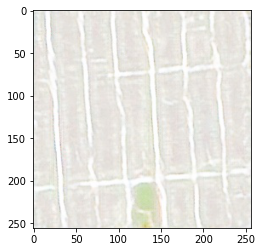

In [30]:
import matplotlib.pyplot as plt

img = plt.imread('./train_output/test_sample/map_translation_test/100.jpg')
plt.imshow(img)

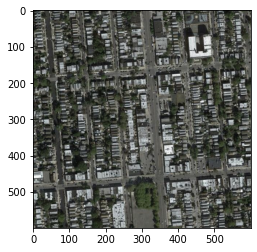

In [31]:
img = plt.imread('./maps/val/100.jpg')
plt.imshow(img)

## 2. Evaluate the generated results with SSIM

### 2.1 import some necessary tools

In [32]:
import time
import os
import numpy as np
import torch
from torch.autograd import Variable
import cv2
from pytorch_ssim import pytorch_ssim
from PIL import Image
import torchvision.transforms as transforms

### 2.2 prepare some parameters for evaluation

In [33]:
gt_file ='./maps/val_tgt/'
results_file='./train_output/test_sample/map_translation_test/' 

transform = transforms.Compose([  \
      transforms.ToTensor(),   \
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])


### 2.3 evaluation loop

In [34]:
loss_all = 0
step = 0
for name in os.listdir(gt_file):
    gt_img = transform(Image.open(os.path.join(gt_file,name))).unsqueeze(0)
    fake_img = transform(Image.open(os.path.join(results_file,name))).unsqueeze(0)


    gt_img = Variable(gt_img).cuda()
    fake_img = Variable(fake_img).cuda()

    loss_all = loss_all + pytorch_ssim.ssim(fake_img,gt_img)

    step += 1
    if step % 100 == 0:
        print('The current ssim score of step {} is {}'.format(step, loss_all/step))

print('-'*60)
print('The overall ssim score of step {} is {}'.format(step, loss_all/step))      
print('-'*60)

The current ssim score of step 100 is 0.47871458530426025
The current ssim score of step 200 is 0.4828324317932129
The current ssim score of step 300 is 0.4828660190105438
The current ssim score of step 400 is 0.4872671663761139
The current ssim score of step 500 is 0.4866003394126892
------------------------------------------------------------
The overall ssim score of step 549 is 0.48654335737228394
------------------------------------------------------------


``

-----

# Others
Once you are familar with runing the code. You can also use the following command for training in the remote terminal, which may be more simple and efficient for you.
- `bash train.sh`

and use the following command for inference,
- `bash test.sh`

Then, you can type the following script for SSIM evaluation (remeber to change the path in test.py file),
- `cd pytorch_ssim`
- `python test.py`

-----

# GOOD LUCK
For any questions about the assignment, please contact the TA (Chongjian GE) via email (rhettgee@connect.hku.hk).